<a href="https://colab.research.google.com/github/coder-penguin/ML/blob/master/tutorial/keras_tutorial_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Sample code for multi classification with CNN

Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.externals import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model, model_to_dot, to_categorical
from IPython.display import SVG

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


2.2.0-rc2


In [3]:
#check GPU
tf.test.gpu_device_name()

'/device:GPU:0'

Read data

In [0]:
# read hand-written dataset
mnist = fetch_openml(name='mnist_784')

In [4]:
#784 = 28*28 pixels
mnist['data'].shape

(70000, 784)

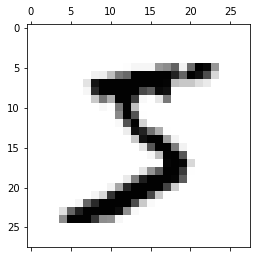

In [5]:
# show data
plt.matshow(mnist['data'][0].reshape(28,28), cmap="Greys")
plt.show()

In [0]:
# image(numpy.ndarray)
X = mnist.data/255

# label(numpy.ndarray)
y = mnist.target

In [0]:
#split dataset to train and test dataset
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)#default is True

In [9]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

56000 14000
56000 14000


In [0]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
y_train_onehot = to_categorical(y_train, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)
y_train = [int(x) for x in y_train]
y_test = [int(x) for x in y_test]

In [11]:
print(X_train.shape, X_test.shape)
print(y_train_onehot.shape, y_test_onehot.shape)

(56000, 28, 28, 1) (14000, 28, 28, 1)
(56000, 10) (14000, 10)


###Train model

In [0]:
def build_model():
  activation = 'elu'
  model = Sequential([
    Conv2D(32,3, input_shape=(28, 28, 1)),#filters, kernel_size
    Activation(activation),
    Conv2D(64,3),
    Activation(activation),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(128),
    BatchNormalization(),
    Activation(activation),
    Dropout(0.5),
    Dense(32, activation=activation),
    Dense(10, activation='softmax')
  ], name='my_model')

  #compile
  loss = 'categorical_crossentropy'
  optimizer = SGD(lr=0.005, nesterov=True)
  model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

  return model

In [0]:
model = build_model()

In [14]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0  

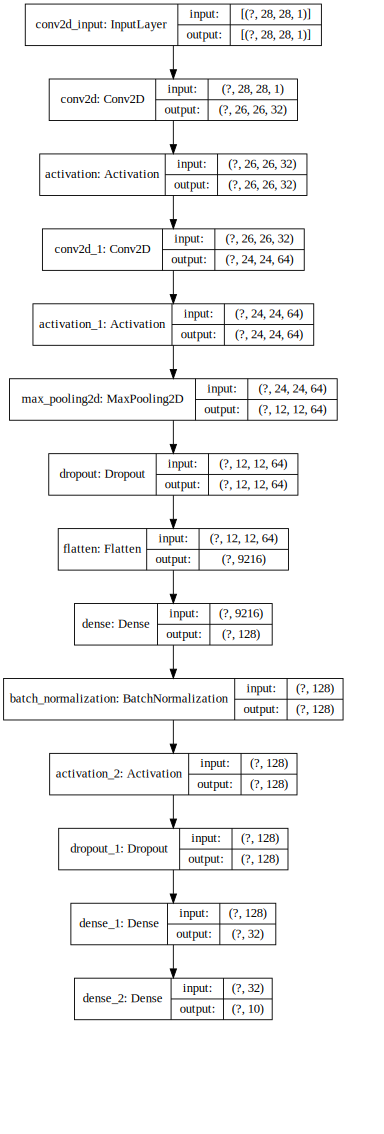

In [15]:
#show model
SVG(model_to_dot(model, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [0]:
!mkdir log

In [0]:
callbacks = [#EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True), #stop training if there is no improvement
                   ModelCheckpoint('./log/model_{epoch:03d}_{val_loss:.4f}.h5', save_best_only=True) #save models
                   ]

In [18]:
history = model.fit(X_train, y_train_onehot, epochs=100, batch_size=32, validation_split=0.1, callbacks=callbacks)

Epoch 1/100
1575/1575 [==============================] - 7s 5ms/step - loss: 0.4086 - accuracy: 0.8792 - val_loss: 0.1508 - val_accuracy: 0.9593
Epoch 2/100
1575/1575 [==============================] - 7s 4ms/step - loss: 0.1974 - accuracy: 0.9422 - val_loss: 0.1068 - val_accuracy: 0.9679
Epoch 3/100
1575/1575 [==============================] - 7s 4ms/step - loss: 0.1526 - accuracy: 0.9548 - val_loss: 0.0862 - val_accuracy: 0.9718
Epoch 4/100
1575/1575 [==============================] - 7s 4ms/step - loss: 0.1280 - accuracy: 0.9619 - val_loss: 0.0733 - val_accuracy: 0.9773
Epoch 5/100
1575/1575 [==============================] - 7s 5ms/step - loss: 0.1128 - accuracy: 0.9661 - val_loss: 0.0644 - val_accuracy: 0.9798
Epoch 6/100
1575/1575 [==============================] - 7s 4ms/step - loss: 0.1013 - accuracy: 0.9695 - val_loss: 0.0610 - val_accuracy: 0.9796
Epoch 7/100
1575/1575 [==============================] - 7s 4ms/step - loss: 0.0934 - accuracy: 0.9712 - val_loss: 0.0557 - val_ac

In [0]:
def plot_loss_and_accuracy(history):
  plt.figure(figsize=(12, 4))
  plt.subplot(121)
  plt.plot(history.epoch, history.history["accuracy"], label="train_accuracy")
  plt.plot(history.epoch, history.history["val_accuracy"], label="val_accuracy")
  plt.xlabel("epoch")
  plt.legend()

  plt.subplot(122)
  plt.plot(history.epoch, history.history["loss"], label="train_loss")
  plt.plot(history.epoch, history.history["val_loss"], label="val_loss")
  plt.xlabel("epoch")
  plt.legend()

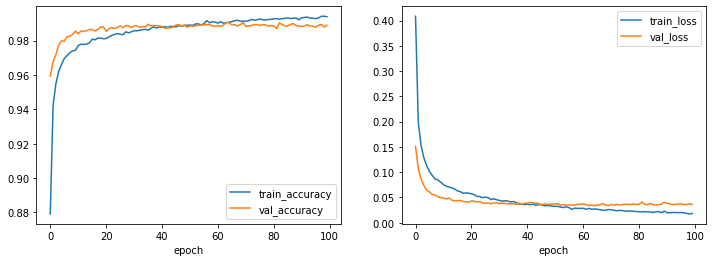

In [20]:
plot_loss_and_accuracy(history)

###Evaluation

k-th cross validation

In [0]:
def cross_validation(X, y, cv=None, epochs=100, batch_size=32):
  kf = KFold(n_splits=cv, shuffle=True)

  y_probas = [0] * len(y)
  accuracy_list = []
  for train_index, val_index in kf.split(X, y):
    train_data = X[train_index]
    train_label = y[train_index]
    val_data = X[val_index]
    val_label = y[val_index]

    model = build_model()
    history = model.fit(train_data, train_label, epochs=epochs, batch_size=batch_size, validation_data=(val_data, val_label))
    val_probas = model.predict(val_data)
    for i, index in enumerate(val_index):
      y_probas[index] = val_probas[i]

    plot_loss_and_accuracy(history)

    accuracy = np.max(history.history['val_accuracy'])
    print('accuracy : ', accuracy)
    accuracy_list.append(accuracy)

  print('accuracy : ', np.mean(accuracy_list), ' +- ', np.std(accuracy_list))  

  return y_probas

In [0]:
#k-th cross validation
cv = 3 #the number of foldings
y_train_probas = cross_validation(X_train, y_train_onehot, cv=cv, epochs=50)

confusion matrix

In [0]:
#calculate confusion matrix
y_train_pred = np.argmax(y_train_probas, axis=1)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [0]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [0]:
#convert to error probability
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#set diagonal to 0 for visibility
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

various scores

In [0]:
accuracy_score(y_train, y_train_pred)

###Test

In [0]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, batch_size=128)

In [0]:
print('test loss : ', test_loss, ', accuracy : ', test_accuracy)

In [0]:
y_test_probas = model.predict(X_test)

In [0]:
y_test_pred = np.argmax(y_test_probas, axis=1)

In [0]:
print(y_test_pred)

###Save

In [0]:
#save the prediction
submissiondir = '.'
submissionname = 'submission'
pd.DataFrame(data={'target':y_test, 'prediction':y_test_pred}).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=["Id"])

In [0]:
# save the model
filename = 'model.h5'
model.save(filename)

In [0]:
# load the model
loaded_model = load_model(filename)
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_onehot, batch_size=128)

In [0]:
print('test loss : ', test_loss, ', accuracy : ', test_accuracy)

##Visualization of the trained model

In [0]:
models_vis = {}
for i, layer in enumerate(model.layers):
  if '2d' in layer.name :
    models_vis[layer.name] = Sequential()
    for j in range(i+1):
      models_vis[layer.name].add(model.layers[j])

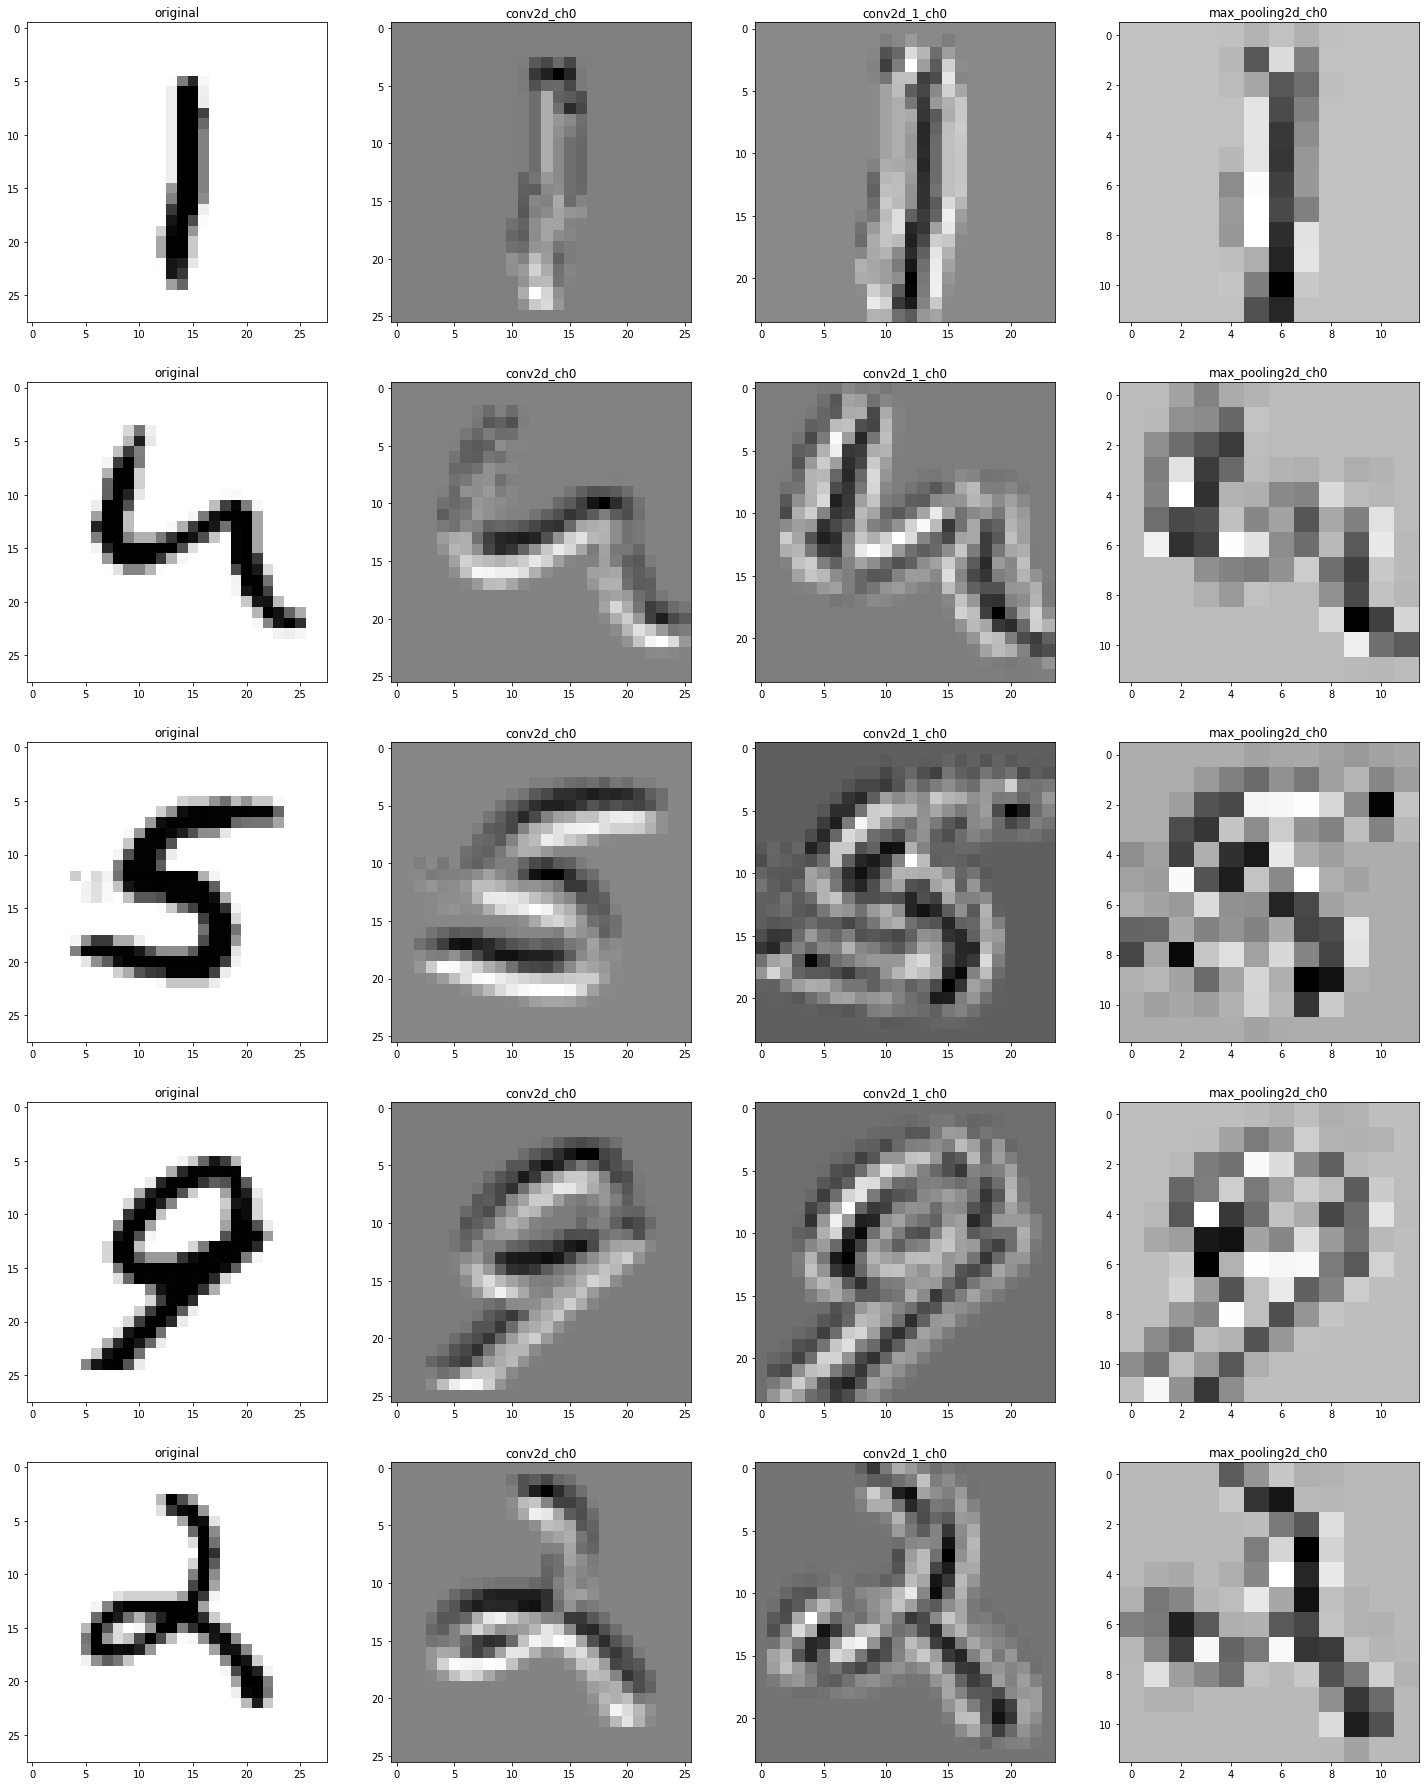

In [92]:
m = 1
n = len(models_vis) * m + 1
n_examples = 5
fig = plt.figure(figsize=(5*n_examples, 8*n))
for i in range(n_examples):
  ax = fig.add_subplot(n_examples, n, n*i+1)
  ax.set_title('original')
  ax.imshow(X_test[i][:, :, 0], cmap='gray_r')
  for j, key in enumerate(models_vis):
    for k in range(m):
      ax = fig.add_subplot(n_examples, n, n*i+2+j+k*len(models_vis))
      ax.set_title(key + '_ch' + str(k))
      ax.imshow(models_vis[key].predict(X_test[i:i+1])[0][:, :, k], cmap='gray_r')

plt.show()

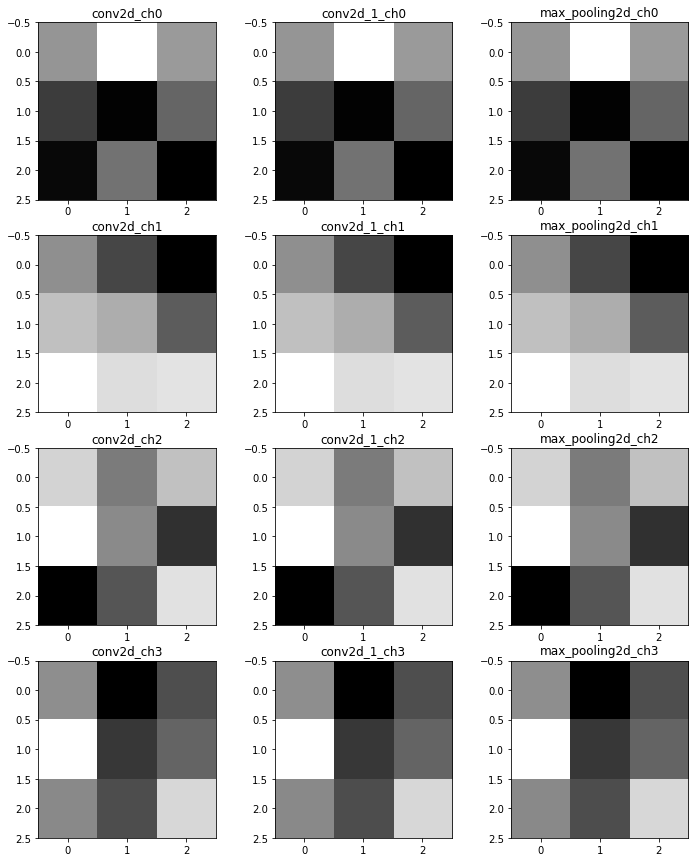

In [88]:
n = len(models_vis)
m = 4
fig = plt.figure(figsize=(3*m,5*n))
for i, key in enumerate(models_vis):
  for j in range(m):
    w = models_vis[key].get_weights()[0][:, :, 0, j]
    ax = fig.add_subplot(m, n, i + n*j + 1)
    ax.set_title(key+'_ch'+str(j))
    ax.imshow(w, cmap='gray_r')
plt.show()